# Data Science Take-Home
Author: Agnes He <br>
Date: Oct 08, 2023
## Problem statement
Fetch provides value to our user base through the rich variety of offers that are active in the app. We want our users to be able to easily seek out offers in the app, so that they get the most out of using the app and our partners get the most out of their relationship with Fetch. <br>
For this assignment, **you will build a tool that allows users to intelligently search for offers via text input from the user.** <br>
You will be provided with a dataset of offers and some associated metadata around the retailers and brands that are sponsoring the offer. You will also be provided with a dataset of some brands that we support on our platform, and the categories that those products belong to.
## Asymmetric Semantic Search
From the problem statement, we want to allow the user to input some short query for brands, retailers or category, and the model will return the top k offers that are related to the search query. This problem could be considered as an **asymmetric sementic search**.

# 0. Import dependencies

In [1]:
import numpy as np
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, util

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# 1. EDA & Preprocess
#### There are three csv files provided. Using Pandas to read all three dataset into pandas dataframes and preforms simple EDA to understand the data. 
#### For each dataset, normalize the column names so the similar features in different datasets have the same name. Normalization are also needed for text data for model training.

In [2]:
brand_df = pd.read_csv('data/brand_category.csv')
brand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9906 entries, 0 to 9905
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   BRAND                      9905 non-null   object
 1   BRAND_BELONGS_TO_CATEGORY  9906 non-null   object
 2   RECEIPTS                   9906 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 232.3+ KB


In [3]:
brand_df.head()

,BRAND,BRAND_BELONGS_TO_CATEGORY,RECEIPTS
0,CASEYS GEN STORE,Tobacco Products,2950931
1,CASEYS GEN STORE,Mature,2859240
2,EQUATE,Hair Removal,893268
3,PALMOLIVE,Bath & Body,542562
4,DAWN,Bath & Body,301844


In [4]:
# Drop unuseful column RECEIPTS, change all column names to lowercases.
brand_df.drop(['RECEIPTS'], axis=1, inplace=True)
brand_df.rename(columns={'BRAND':'brand', 'BRAND_BELONGS_TO_CATEGORY':'category'}, inplace=True)

In [5]:
# Count unique values in each columns
brand_df.nunique()

brand       8521
category     118
dtype: int64

#### Number of unique values in brand is less than the total number, thus some brand may contains multiple categories. We want to join concatenate the categories for each brand.

In [6]:
# Some brand may contains multiple categories
(brand_df.groupby(['brand']).count()>1).sum()

category    717
dtype: int64

In [7]:
brand_df = brand_df.groupby('brand').agg(lambda col: ','.join(col)).reset_index()

In [8]:
cat_df = pd.read_csv('data/categories.csv')
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CATEGORY_ID           118 non-null    object
 1   PRODUCT_CATEGORY      118 non-null    object
 2   IS_CHILD_CATEGORY_TO  118 non-null    object
dtypes: object(3)
memory usage: 2.9+ KB


In [9]:
cat_df.head()

,CATEGORY_ID,PRODUCT_CATEGORY,IS_CHILD_CATEGORY_TO
0,1f7d2fa7-a1d7-4969-aaf4-1244f232c175,Red Pasta Sauce,Pasta Sauce
1,3e48a9b3-1ab2-4f2d-867d-4a30828afeab,Alfredo & White Pasta Sauce,Pasta Sauce
2,09f3decc-aa93-460d-936c-0ddf06b055a3,Cooking & Baking,Pantry
3,12a89b18-4c01-4048-94b2-0705e0a45f6b,Packaged Seafood,Pantry
4,2caa015a-ca32-4456-a086-621446238783,Feminine Hygeine,Health & Wellness


In [10]:
cat_df.nunique()

CATEGORY_ID             118
PRODUCT_CATEGORY        118
IS_CHILD_CATEGORY_TO     23
dtype: int64

In [11]:
# Drop unuseful column RECEIPTS, change all column names to lowercases.
cat_df.drop(['CATEGORY_ID'], axis=1, inplace=True)
cat_df.rename(columns={'PRODUCT_CATEGORY':'category', 'IS_CHILD_CATEGORY_TO':'parent_category'}, inplace=True)

In [12]:
offer_df = pd.read_csv('data/offer_retailer.csv')
offer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   OFFER     384 non-null    object
 1   RETAILER  238 non-null    object
 2   BRAND     384 non-null    object
dtypes: object(3)
memory usage: 9.1+ KB


In [13]:
offer_df.head()

,OFFER,RETAILER,BRAND
0,Spend $50 on a Full-Priced new Club Membership,SAMS CLUB,SAMS CLUB
1,"Beyond Meat® Plant-Based products, spend $25",NaN,BEYOND MEAT
2,Good Humor Viennetta Frozen Vanilla Cake,NaN,GOOD HUMOR
3,"Butterball, select varieties, spend $10 at Dil...",DILLONS FOOD STORE,BUTTERBALL
4,"GATORADE® Fast Twitch®, 12-ounce 12 pack, at A...",AMAZON,GATORADE


In [14]:
offer_df.nunique()

OFFER       376
RETAILER     61
BRAND       144
dtype: int64

In [15]:
offer_df.rename(columns={'OFFER':"offer", 'RETAILER':'retailer', 'BRAND':'brand'}, inplace=True)

In [16]:
def col_lowercase(df):
    for col in df.columns:
        df[col] = df[col].str.lower()
    return df

In [17]:
brand_df = col_lowercase(brand_df[['brand', 'category']])
cat_df = col_lowercase(cat_df[['category', 'parent_category']])
offer_df[['retailer', 'brand']] = col_lowercase(offer_df[['retailer', 'brand']])

<ipython-input-16-8dd7205be92b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.lower()


In [18]:
# Merge all columns 
df = pd.merge(offer_df, brand_df, on='brand', how='left')
df = pd.merge(df, cat_df, on='category', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   offer            388 non-null    object
 1   retailer         242 non-null    object
 2   brand            388 non-null    object
 3   category         338 non-null    object
 4   parent_category  157 non-null    object
dtypes: object(5)
memory usage: 15.3+ KB


In [19]:
df.head()

,offer,retailer,brand,category,parent_category
0,Spend $50 on a Full-Priced new Club Membership,sams club,sams club,NaN,NaN
1,"Beyond Meat® Plant-Based products, spend $25",NaN,beyond meat,"plant-based meat,frozen plant-based meat,packa...",NaN
2,Good Humor Viennetta Frozen Vanilla Cake,NaN,good humor,"frozen desserts,dips & salsa",NaN
3,"Butterball, select varieties, spend $10 at Dil...",dillons food store,butterball,"nut butters & jam,frozen turkey",NaN
4,"GATORADE® Fast Twitch®, 12-ounce 12 pack, at A...",amazon,gatorade,"sports drinks,medicines & treatments,meal repl...",NaN


Fill null as empty strings.

In [20]:
df.fillna('', inplace=True)

#### First, we create a lookup corpus. Then, for a given query sentence, we want to find the most similar sentence in this corpus.

In [21]:
df['corpus'] = df.apply(lambda col: '|'.join(col), axis=1)
df.head()

,offer,retailer,brand,category,parent_category,corpus
0,Spend $50 on a Full-Priced new Club Membership,sams club,sams club,,,Spend $50 on a Full-Priced new Club Membership...
1,"Beyond Meat® Plant-Based products, spend $25",,beyond meat,"plant-based meat,frozen plant-based meat,packa...",,"Beyond Meat® Plant-Based products, spend $25||..."
2,Good Humor Viennetta Frozen Vanilla Cake,,good humor,"frozen desserts,dips & salsa",,Good Humor Viennetta Frozen Vanilla Cake||good...
3,"Butterball, select varieties, spend $10 at Dil...",dillons food store,butterball,"nut butters & jam,frozen turkey",,"Butterball, select varieties, spend $10 at Dil..."
4,"GATORADE® Fast Twitch®, 12-ounce 12 pack, at A...",amazon,gatorade,"sports drinks,medicines & treatments,meal repl...",,"GATORADE® Fast Twitch®, 12-ounce 12 pack, at A..."


In [22]:
corpus = df['corpus']

#### Randomly sampling one row to verify the strings.

In [23]:
print(corpus.sample(1).values[0])

Shop 2 times at Vons|vons|vons|spirits|alcohol


# 2. Modeling

<AxesSubplot:>

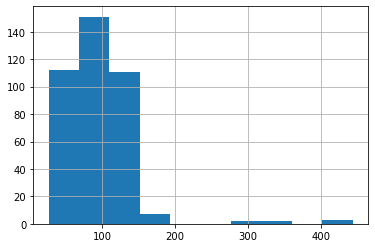

In [24]:
# Plot the distribution of charactor length of the OFFERs
corpus.apply(len).hist()

#### The length of each offer is less than 400 characters. Therefore we can choose a model that is suitable for short paragraphs. In SBert, the pre-trained models are tuned for cosine-similarity or dot-product. Models tuned for cosine-similarity will prefer the retrieval of short documents, while models tuned for dot-product will prefer the retrieval of longer documents. <br>
![image](img/sbert_models.png)
#### Hence, for this project, we will choose msmarco-distilbert-base-v4.

In [25]:
embedder = SentenceTransformer('msmarco-distilbert-base-v4')
embedder.max_seq_length = 256
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True, show_progress_bar=True)

In [26]:
# Query sentences:
queries = ['walmart frozen', 'dove', 'frozen']

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = min(5, len(corpus))
for query in queries:
    query_embedding = embedder.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:\n")

    for score, idx in zip(top_results[0], top_results[1]):
        print(df.iloc[idx.item()]['offer'], "(Score: {:.4f})".format(score))





Query: walmart frozen

Top 5 most similar sentences in corpus:

Tyson Products, select varieties, spend $15 at Walmart (Score: 0.3872)
Gorton's at select retailers (Score: 0.3813)
Gorton's Air Fried Butterfly Shrimp, at Walmart (Score: 0.3759)
Breyers Reese's Ice Cream, select varieties, at GIANT OR MARTIN’S (Score: 0.3687)
Thomas'® Bagel Thins (Score: 0.3612)




Query: dove

Top 5 most similar sentences in corpus:

DOVE® chocolate, select varieties (Score: 0.3457)
Dove Hand Wash, select varieties, buy 2 at Target (Score: 0.3245)
Dove Hand Wash, select varieties at Target (Score: 0.3209)
DOVE® Chocolate, select sizes, buy 1 (Score: 0.3036)
Bays® English Muffins (Score: 0.1961)




Query: frozen

Top 5 most similar sentences in corpus:

Thomas'® Bagel Thins (Score: 0.3127)
Talenti Mini Bars (Score: 0.2834)
Ben & Jerry's®, select varieties, spend $12 (Score: 0.2820)
GOYA® Coconut Water (Score: 0.2702)
Thomas'® Bagel Thins®, buy 2 (Score: 0.2678)


In [27]:
top_results

torch.return_types.topk(
values=tensor([0.3127, 0.2834, 0.2820, 0.2702, 0.2678]),
indices=tensor([385,  75, 201, 166, 124]))

In [28]:
res = pd.DataFrame({'Score':top_results[0], 'Offer':df.iloc[top_results[1].tolist()]['offer']})
res

,Score,Offer
385,0.312730,Thomas'® Bagel Thins
75,0.283373,Talenti Mini Bars
201,0.281968,"Ben & Jerry's®, select varieties, spend $12"
166,0.270156,GOYA® Coconut Water
124,0.267818,"Thomas'® Bagel Thins®, buy 2"


In [29]:
# Wrap the code to a search function
def search(query, top_k):
    query_embedding = embedder.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("Query:", query)
    print("\n============================\n")
    print("\nTop 5 most similar sentences in corpus:\n")

    for score, idx in zip(top_results[0], top_results[1]):
        print(df.iloc[idx.item()]['offer'], "(Score: {:.4f})".format(score))

# 3. Testing

In [30]:
# Search for a product
search('chocolate icecream', 5)

Query: chocolate icecream



Top 5 most similar sentences in corpus:

Reese's Chocolate Cones, 8 count at GIANT OR MARTIN’S (Score: 0.3294)
Reese's Chocolate Cones, 8 count at GIANT OR MARTIN’S (Score: 0.3210)
LIFE SAVERS® (Score: 0.3176)
DOVE® chocolate, select varieties (Score: 0.3138)
Marinela® sweet baked goods, buy 2 (Score: 0.3070)


In [31]:
# Retailer
search('Target', 10)

Query: Target



Top 5 most similar sentences in corpus:

Arber, at Target (Score: 0.5044)
L'Oréal Paris Makeup, spend $35 at Target (Score: 0.3750)
L'Oréal Paris Makeup, spend $30 at Target (Score: 0.3743)
L'Oreal Paris True Match Foundation at Target (Score: 0.3549)
L'Oréal Paris True Match Foundation at Target (Score: 0.3549)
L'Oréal Paris Hair color, select varieties, spend $25 at Target (Score: 0.2908)
Dove Hand Wash, select varieties at Target (Score: 0.2760)
L'Oréal Paris Excellence Hair Color at Target (Score: 0.2744)
L'Oréal Paris Hair color, select varieties, spend $19 at Target (Score: 0.2726)
Dove Hand Wash, select varieties, buy 2 at Target (Score: 0.2721)


In [32]:
# Category
search('liquor', 10)

Query: liquor



Top 5 most similar sentences in corpus:

Sol® 6 pack+ (Score: 0.3605)
Any Vons receipt (Score: 0.3401)
Shop 2 times at Vons (Score: 0.2830)
Spend $150 at Vons (Score: 0.2726)
Spend $100 at Vons (Score: 0.2696)
Spend $275 at Vons (Score: 0.2636)
Sign up for McAlister's Deli Rewards, tap for details (Score: 0.2543)
Coors Light®, Miller Lite® OR VIZZY™ 12 pack+ (Score: 0.2529)
Coors Light®, Miller Lite® OR VIZZY™ 12 packs+, buy 3 (Score: 0.2333)
Coors Light®, Miller Lite® OR VIZZY™ 12 packs+, buy 4 (Score: 0.2306)


In [33]:
# Keyword with typo
search('liquir', 5)

Query: liquir



Top 5 most similar sentences in corpus:

Brita® Standard OR Elite Filters (Score: 0.1634)
Coors Light®, Miller Lite® OR VIZZY™ 12 pack+ (Score: 0.1603)
Coors Light®, Miller Lite® OR VIZZY™ 12 packs+, buy 3 (Score: 0.1592)
Coors Light®, Miller Lite® OR VIZZY™ 12 packs+, buy 4 (Score: 0.1572)
Brita® Pitcher AND Filter (Score: 0.1567)


In [34]:
# Empty search
search('', 5)

Query: 



Top 5 most similar sentences in corpus:

Dr Pepper®, Regular OR Zero Sugar Strawberries and Cream 12 pack, at select retailers (Score: 0.1117)
Squirrel, The Bedside Perch, online at Amazon (Score: 0.1063)
Welch's® Zero Sugar Fruity Bites, 6 pack+, online at Amazon (Score: 0.0860)
EXTRA®, select varieties (Score: 0.0808)
EXTRA®, select sizes (Score: 0.0800)


# 4. Deployment
#### The Semantic Search tool was deployed on Hugging Face's Spaces platform, making it readily available for users to access. 

In [ ]:
# app.py

import streamlit as st
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch

st.title('Semantic Search Tool Using SBERT')
st.markdown(
    """
	Fetch provides value to our user base through the rich variety of offers
    that are active in the app. We want our users to be able to easily seek 
    out offers in the app, so that they get the most out of using the app 
    and our partners get the most out of their relationship with Fetch. 
    Semantic Search model was utilized to search for relevant offers based 
    on user-provided keywords, such as categories, brands, or retailers.
    """
)

embedder = SentenceTransformer('msmarco-distilbert-base-v4')
embedder.max_seq_length = 256
df = pd.read_csv('data.csv', index_col=0).fillna("")
corpus = df['corpus']
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True, show_progress_bar=True)

def search(query, top_k):
    """Search the closest k results to input query
    Args:
        query: A string value
        top_k: A integer between 1 and corpus length
        
    Returns:
        top_results: a tuple contains the scores and indices of the top k results.
    """
    query_embedding = embedder.encode(query, convert_to_tensor=True)
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)
    
    return top_results
	
with st.form("my_form"):
    query = st.text_input("Enter keywords to search for relevant offers, e.g. 'Walmart', 'ice cream', etc. ", placeholder = "Search:")
    k = st.number_input('Top K relevent offers', min_value=3, max_value=10)
    submitted = st.form_submit_button("Submit")
    if submitted:
        top_results = search(query, k)
        for score, idx in zip(top_results[0], top_results[1]):
            st.write(df.iloc[idx.item()]['offer'], "(Score: {:.4f})".format(score))
        st.write("\nFinished searching.")